# Import libs
We are going to need quite a few libraries. Let’s load them.

In [1]:
# !python -m spacy download en
# !python -m spacy download fr
# nltk.download('stopwords')

import re
import numpy as np
import pandas as pd 
from pprint import pprint
pd.set_option("display.max_colwidth", 200)

# NLTK 
from nltk import FreqDist
from nltk.corpus import stopwords

# Spacy for lemmatisation
import spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

# visualization libs
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns


# Init the stopwords
stop_words = set(stopwords.words('english'))


# load the spacy model
nlp = spacy.load('en', disable=['parser', 'ner'])

C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Read the data
Load the dataset stored in csv file that we previously scrapped from the Google Android Store.µ 

In [2]:
df = pd.read_csv("scraped_reviews/instagram.csv")
reviews = df.review.values.tolist()

# Data Preprocessing
Data preprocessing and cleaning is an important step before any text mining task, in this step, we will remove the punctuations, stopwords and normalize the reviews as much as possible. After every preprocessing step, it is a good practice to check the most frequent words in the data. Therefore, let’s define a function that would plot a bar graph of n most frequent words in the data.

In [3]:
def word_freq(reviews, N = 30):
    
  # Concatenations des reviews, et création de la liste de tous les mots.
  reviews_concatenated = ' '.join([str(review) for review in reviews])
  words = reviews_concatenated.split()

  # Map each word with the number of its occurence
  fdist = FreqDist(words)
  df_word_occurence = pd.DataFrame(data = {'Word':list(fdist.keys()), 'Occurence':list(fdist.values())})
  d = df_word_occurence.nlargest(columns="Occurence", n = N)

  # plot the word occurence graphic 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "Word", y = "Occurence")
  plt.show()

## Reviews before preprocessing
Let’s try this function and find out which are the most common words in our raw reviews dataset (before preprocessing).

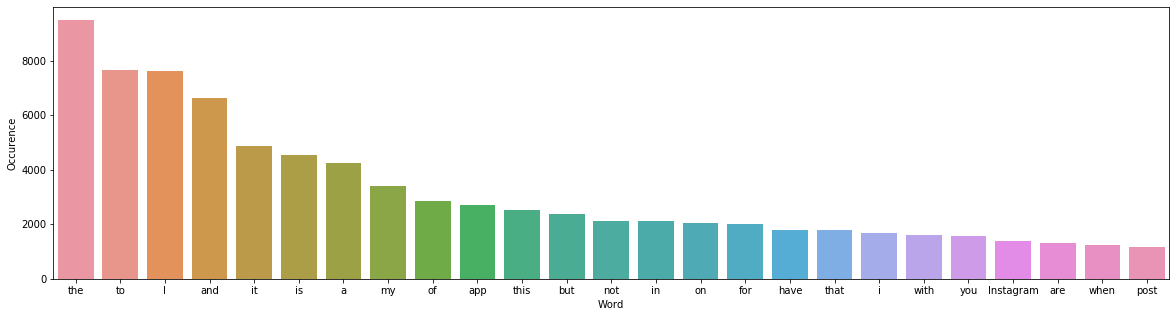

In [4]:
word_freq(df.review.values.tolist(), 25)

## Data cleaning & preprocessing
From above code we see that most common words are ‘the’, ‘to’, ‘and’, etc. These words are not so important for our task and they do not tell any story. We’ have to get rid of these kinds of words. Pre-processing and data cleaning are important steps before any text mining task, in these steps we will remove punctuation, numeric values, empty words and standardize the reviews as much as possible.

Let’s again plot the most frequent words on our cleaned reviews and see if the more significant words have come out.

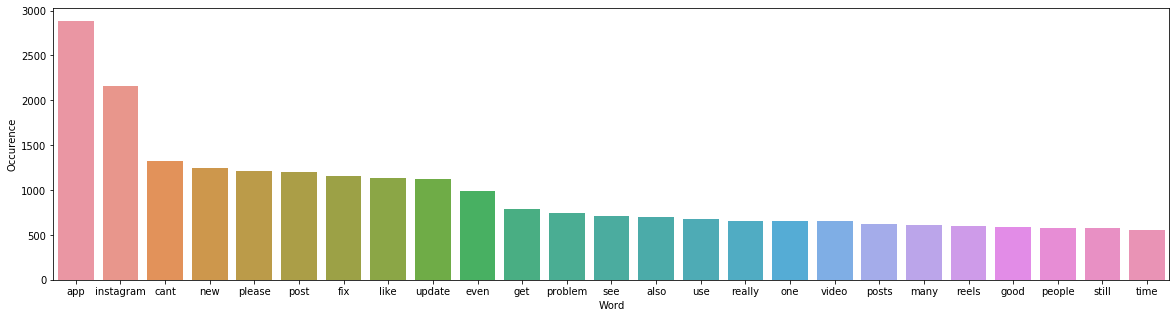

In [7]:
def stopwords_elimination(review):
    """ 
    Eliminate all stop_words from a review
    """
    new_review = " ".join([word for word in str(review).split() if word not in stop_words])
    return new_review


def clean_data(reviews):
    """ 
    Cleaning & Preprocessing text data
    """
    # Lowercase words
    reviews = [str(review).lower() for review in reviews]
    # Eliminate StopWords
    reviews = [stopwords_elimination(review) for review in reviews]
    # Eliminates Emails
    reviews = [re.sub(r'\S*@\S*\s?', '', str(review)) for review in reviews]
    # Eliminate new line
    reviews = [re.sub(r'\s+', ' ', str(review)) for review in reviews]
    # Eliminate single quotes
    reviews = [re.sub("\'", "", review) for review in reviews]
    # Eliminates words where len(word) < 3
    reviews = [' '.join([word for word in review.split() if len(word)>2]) for review in reviews]
    return reviews

clean_reviews = clean_data(df.review.values.tolist())
word_freq(clean_reviews, 25)

## Lemmatization :
We can see some improvement here. Terms like ‘update’, ‘like’, ‘video’, have come up which are quite relevant for the Instagram dataset. However, we still have neutral terms which are not that relevant.

To further remove noise from the text we can use lemmatization from the spaCy library. Lemmatization is a lexical treatment applicable to a text. It consists in applying to the occurrences of lexemes subject to flexion a coding referring to their common lexical entry ("canonical form"), which is called lemma. It reduces any given word to its base form thereby reducing multiple forms of a word to a single word.


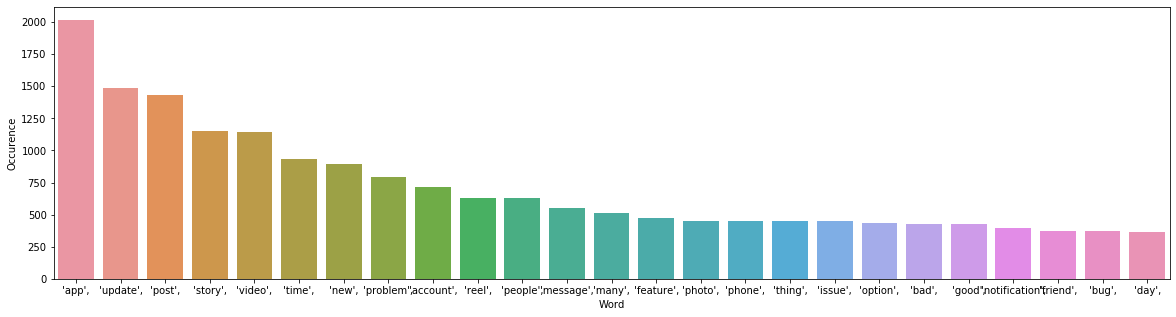

In [9]:
def tokenization_lemmatization(reviews):
    """
    Fonction to tokenize and lemmatize the cleaned reviews
    """
    tags=['NOUN', 'ADJ']
    tokenized_reviews = []; lemmatized_reviews = []; reviews2 = []
    
    # Tokenize the reviews. 
    tokenized_reviews = pd.Series(reviews).apply(lambda x: str(x).split());     
    
    # Lemmatize des reviews. We store each review as a Spacy doc object.
    for review in tokenized_reviews:
        doc_review = nlp(" ".join(review)) 
        lemmatized_reviews.append([token.lemma_ for token in doc_review if token.pos_ in tags])
    
    for i in range(len(lemmatized_reviews)):
        reviews2.append(' '.join(lemmatized_reviews[i]))
    return lemmatized_reviews


lemmatized_reviews = tokenization_lemmatization(clean_reviews)
word_freq(lemmatized_reviews, 25)

# Build the document term matrix
We start by creating the dictionary by passing the list of lemmatized reviews to it. The latter will be made up of all the words contained in the reviews. Each word appears only once. For each word, the dictionary has meta data about the word, number of occurrences etc...

The doc2bow() method applied to a review returns a tuple list of the form (id_word, number_occurrences). We apply this method to all our reviews, we then get a list of lists that will represent our document term correspondence matrix. Each element of the matrix represents one review.


In [10]:
# Creat dictionnary : https://www.machinelearningplus.com/nlp/gensim-tutorial/
reviews_dictionnary = corpora.Dictionary(lemmatized_reviews)

# Filter the dictionnary
reviews_dictionnary.filter_extremes(no_below=20, no_above=0.5)

# Creat the document term matrix
doc_term_matrix = [reviews_dictionnary.doc2bow(review) for review in lemmatized_reviews]

# Building an LDA model
Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. LDA expands to Latent Dirichlet Allocation (LDA) is an example of a model which is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

We will be using the gensim version of LDA model. The code above will take a while. Please note that I have specified the number of topics as 7 for this model using the NTopics parameter. You can specify any number of topics using the same parameter.

In [14]:
def LDA_MODELE(dictionnary, doc_term_matrix, NTopics):
    """
    Build and return a Gensim LDA model.
    """
    # Init a Gensim  LDA model
    LDA = gensim.models.ldamodel.LdaModel
    
    # LDA construction from the document term matrix
    lda_model = LDA(corpus=doc_term_matrix, 
               id2word=dictionnary,
               num_topics=NTopics, 
               random_state=1000, 
               chunksize=100, 
               passes=50,
               alpha=[0.01]*NTopics,
               eta=[0.01]*len(dictionnary.keys()))
    
    # Return the model
    return lda_model

lda_model = LDA_MODELE(reviews_dictionnary, doc_term_matrix, NTopics=7)

The objective function for LDA is non-convex, making it a multimodal problem. In layman’s terms, LDA topic modeling won’t give you one single best solution, it’s an optimization problem. Now let’s print out the topics that our LDA model has learned.

In [15]:
lda_model.print_topics()

[(0,
  '0.174*"app" + 0.116*"good" + 0.074*"great" + 0.057*"friend" + 0.048*"music" + 0.047*"people" + 0.046*"thing" + 0.042*"social" + 0.042*"medium" + 0.039*"recent"'),
 (1,
  '0.149*"problem" + 0.142*"time" + 0.113*"many" + 0.053*"account" + 0.046*"comment" + 0.039*"report" + 0.029*"filter" + 0.029*"request" + 0.024*"disabled" + 0.023*"function"'),
 (2,
  '0.086*"post" + 0.040*"new" + 0.040*"update" + 0.034*"people" + 0.034*"story" + 0.024*"platform" + 0.024*"bad" + 0.022*"share" + 0.021*"app" + 0.020*"button"'),
 (3,
  '0.094*"app" + 0.047*"time" + 0.042*"problem" + 0.039*"issue" + 0.038*"day" + 0.035*"notification" + 0.035*"open" + 0.032*"update" + 0.029*"fix" + 0.027*"good"'),
 (4,
  '0.088*"account" + 0.048*"text" + 0.039*"follower" + 0.037*"page" + 0.032*"internet" + 0.031*"load" + 0.030*"scroll" + 0.028*"reel" + 0.026*"camera" + 0.025*"big"'),
 (5,
  '0.207*"video" + 0.067*"story" + 0.063*"upload" + 0.055*"picture" + 0.052*"post" + 0.047*"last" + 0.043*"photo" + 0.042*"screen"

# Visualise the Topics Modeling using PyLDAvis
PyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data, by showing them visually : 
* The size of the bubble measures the importance of the topics, relative to the data.
* Saliency: a measure of how much the term tells you about the topic.
* Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
First, we got the most salient terms, means terms mostly tell us about what’s going on relative to the topics. We can also look at individual topic

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, reviews_dictionnary, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.044862 -0.275590       1        1  23.812750
3     -0.066976  0.050000       2        1  23.013330
6      0.128713  0.218189       3        1  15.456746
5      0.411177  0.090629       4        1  13.572992
0      0.233044 -0.357960       5        1   9.757821
4     -0.449652 -0.128080       6        1   8.089005
1     -0.211444  0.402813       7        1   6.297345, topic_info=        Term         Freq        Total Category  logprob  loglift
40     video  1499.000000  1499.000000  Default  30.0000  30.0000
0        app  2722.000000  2722.000000  Default  29.0000  29.0000
26      time  1153.000000  1153.000000  Default  28.0000  28.0000
25   problem  1421.000000  1421.000000  Default  27.0000  27.0000
6        new  1270.000000  1270.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
144  account   179.534927   910.308350   Topic7  -2.9288   1.1416
201     able    66.617035   512.105957   Topic7  -3.9202   0.7255
96       bug    42.708515   545.626526   Topic7  -4.3648   0.2175
154     user    36.723797   262.280975   Topic7  -4.5157   0.7991
17     issue    31.314823   678.651062   Topic7  -4.6751  -0.3110

[340 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
321       7  0.976208      %
201       1  0.121069   able
201       2  0.236279   able
201       3  0.353442   able
201       6  0.158170   able
...     ...       ...    ...
155       2  0.999693  wrong
114       2  0.248849   year
114       3  0.165900   year
114       5  0.587561   year
305       7  0.993778   zoom

[368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 7, 6, 1, 5, 2])